In [1]:
import pandas as pd
import numpy as np
#import datetime as dt
import random
import time
import matplotlib.pyplot as plt
import math
import gurobipy as gp
from gurobipy import GRB
#from itertools import permutations
from itertools import combinations
from random import choice
import copy
#from scipy.stats import bernoulli
#import json
import cvxpy as cp
from tkinter import _flatten
#import mosek
#from cvxpy import log_sum_exp
import itertools
from scipy.stats import norm,gumbel_r,expon,uniform
from math import comb
#from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
#from sklearn.metrics.cluster import completeness_score
import sklearn

In [2]:
np.random.seed(1)
random.seed(1)

In [3]:
def binarySearch(lb,ub,v,assortment,eps,g1,g2,x,m1,std1,m2,std2):
    
    mid = (lb+ub)/2
    for j in assortment:
        if j in g1:
            x[j] = 1-gumbel_r.cdf(mid-v[j],loc=m1,scale=std1)

        if j in g2:
            x[j] = 1-norm.cdf(mid-v[j],loc=m2,scale=std2)
            #x[j] = 1-gumbel_r.cdf(mid-v[j],loc=m2,scale=std2)
            #x[j] = 1-expon.cdf(mid-v[j],loc=m2,scale=std2)
    
    if np.abs(sum(x)-1)<eps:
        return [mid,x]
    elif sum(x)>1:
        return binarySearch(mid,ub,v,assortment,eps,g1,g2,x,m1,std1,m2,std2)
    else:
        return binarySearch(lb,mid,v,assortment,eps,g1,g2,x,m1,std1,m2,std2)


In [4]:
''' data = np.array([[0,1,2,0],[4,4,3,3],[2,2,2,2]])

# data increasing order for each alternative
pre_ranking = []
raw_rank = np.argsort(data,axis=1) 
print('raw ranking',raw_rank)
for k in range(data.shape[0]): # find all the assortments in each product
        for l in np.nonzero(data[k]): 
            if len(l)>1: 
                pre_ranking.append(raw_rank[k][-len(l):].tolist()) # take the ranking of the nonzero entries
print('the ranking ', pre_ranking)


# find equal turples
equal = [[] for _ in range (data.shape[0])]
repeat_idx = [[] for _ in range (data.shape[0])]
## from the equal elements of each row from the positive elements
for i in range(len(pre_ranking)):
    if len(pre_ranking[i])>1:
        for j in range(len(pre_ranking[i])-1):
                if data[i][j] == data[i][j+1]:
                    equal[i].append([j,j+1])
                    repeat_idx[i].append(j+1)
print(equal)
print(repeat_idx)
# strictly increasing order
ranking = [[] for _ in range(data.shape[0])]
for i in range(data.shape[0]):
    new_set = set(repeat_idx[i])
    ranking[i] = [x for x in pre_ranking[i] if x not in new_set]
print(ranking) '''




" data = np.array([[0,1,2,0],[4,4,3,3],[2,2,2,2]])\n\n# data increasing order for each alternative\npre_ranking = []\nraw_rank = np.argsort(data,axis=1) \nprint('raw ranking',raw_rank)\nfor k in range(data.shape[0]): # find all the assortments in each product\n        for l in np.nonzero(data[k]): \n            if len(l)>1: \n                pre_ranking.append(raw_rank[k][-len(l):].tolist()) # take the ranking of the nonzero entries\nprint('the ranking ', pre_ranking)\n\n\n# find equal turples\nequal = [[] for _ in range (data.shape[0])]\nrepeat_idx = [[] for _ in range (data.shape[0])]\n## from the equal elements of each row from the positive elements\nfor i in range(len(pre_ranking)):\n    if len(pre_ranking[i])>1:\n        for j in range(len(pre_ranking[i])-1):\n                if data[i][j] == data[i][j+1]:\n                    equal[i].append([j,j+1])\n                    repeat_idx[i].append(j+1)\nprint(equal)\nprint(repeat_idx)\n# strictly increasing order\nranking = [[] for _ i

In [5]:
############## calculating pairwise product distribution distance #############
def new_distance2(data,collection,product_i,product_j):
    eps = math.pow(10,-6)
    n,m = data.shape
    
    ind = [[] for i in range(n)]  ## keeps tracking of the assortments including product i 
    for i in range(m):
        for j in collection[i]:
            ind[j].append(i) ## assortment i includes product j 
    
    ineq_num = 0
    eq_num = 0
    for i in ind[product_i]:
        for j in ind[product_j]:
            if data[product_i][i] != data[product_j][j]:
                ineq_num = ineq_num +1
            if data[product_i][i] == data[product_j][j]:
                eq_num = eq_num +1
    if ineq_num + eq_num != len(ind[product_i])*len(ind[product_j]):
        print('counting error!!')
            
    lam = cp.Variable(shape=m)
    v = cp.Variable(shape=2)
    y = cp.Variable(shape=ineq_num)
    y_minus = cp.Variable(shape=ineq_num,nonneg=True)
    if eq_num>0:
        eta = cp.Variable(shape=eq_num)
        z = cp.Variable(shape=eq_num,nonneg=True)
    
    constraints = []
    ## add MDM constaints
    for i in range(n):
        if len(ind[i])>1: ### the comparison happens when there are at least two assortments including product i 
            for j in range(len(ind[i])-1):
                for k in range(j+1,len(ind[i])):
                    if data[i][ind[i][j]] < data[i][ind[i][k]]:
                        constraints += [lam[ind[i][j]] - lam[ind[i][k]] - eps >=0]
                    if data[i][ind[i][k]] < data[i][ind[i][j]]:
                        constraints += [lam[ind[i][k]] - lam[ind[i][j]] - eps >=0]
                    if data[i][ind[i][k]] == data[i][ind[i][j]]:
                        constraints += [lam[ind[i][k]] - lam[ind[i][j]] ==0]
    
    ## grouping constraints 
    con_iq_num = 0
    con_eq_num = 0
    for i in ind[product_i]: ## assortment i includes product_i
        for j in ind[product_j]: ## assortment j includes product_j
                if data[product_i][i] < data[product_j][j]:
                    constraints += [lam[i]-v[0] - lam[j] + v[1] - y[con_iq_num] >=0]
                    constraints += [ y_minus[con_iq_num] + y[con_iq_num] >= 0 ]
                    con_iq_num = con_iq_num +1
                if data[product_j][j] < data[product_i][i]:
                    constraints += [lam[j] - v[1] -lam[i] +v[0] - y[con_iq_num] >=0 ]
                    constraints += [ y_minus[con_iq_num] + y[con_iq_num] >= 0 ]
                    con_iq_num = con_iq_num +1
                if data[product_i][i] == data[product_j][j] and data[product_i][i]>0:
                    constraints += [lam[i]-v[0] - lam[j] + v[1] -eta[con_eq_num] ==0]
                    constraints += [eta[con_eq_num]-z[con_eq_num]<=0]
                    constraints += [eta[con_eq_num]+z[con_eq_num]>=0]
    if eq_num>0:
        obj = cp.Minimize(cp.sum(y_minus)+cp.sum(z))
    else:
        obj = cp.Minimize(cp.sum(y_minus))
    prob = cp.Problem(obj,constraints)
    prob.solve()
    #print(prob.value)
    return prob.value

### control parameter: assortment size

In [6]:
### basic setting: 
###  group 1 with gumbel ditribution 
###  group 2 with normal distribution 
mean_assortment_accuarcy = []
std_assortment_accararcy = []

n = 7
g1 = [0,1,2,3] 
g2 = [4,5,6] 
true_label = [0,0,0,0,1,1,1]
size = [40,60,80,100]
#size = [5]
loop = 50
############ randomly generating the preference parameter v ##############
v = np.random.uniform(-1,1,n)

all_possible_assortment = []
for i in range(2,n):
    new_assortments = [list(x) for x in list(combinations(range(n),i))]
    all_possible_assortment.extend(new_assortments)

for y in range(len(size)):
    accuarcy_score_list = []
    print('begin',size[y])
    for yy in range(loop): 
        assortment_size = size[y]
        
        assortment_collection = []
        ''' all_possible_assortment = []
        for i in range(2,n):
            new_assortments = [list(x) for x in list(combinations(range(n),i))]
            all_possible_assortment.extend(new_assortments) '''
        chosen_idx = random.sample(range(len(all_possible_assortment)),assortment_size)
        chosen_idx.sort()
        for i in chosen_idx:
            assortment_collection.append(all_possible_assortment[i])
            
        choice_prob = np.zeros((n,assortment_size))
        lam = []
        lb = -200
        ub = 200
        eps = 0.000001
        gumbel_mean = np.random.uniform(0,3)
        gumbel_std = np.random.uniform(1,5)
        ''' gumbel_std = np.random.uniform(1,5)
        normal_mean = np.random.uniform(-4,-1)
        normal_std = np.random.uniform(10,20) '''
        normal_mean = np.random.uniform(-5,-1)
        normal_std = np.random.uniform(10,20)
        #normal_mean = np.random.uniform(5,10)
        #normal_std = np.random.uniform(1,5)

        for i in range(assortment_size):
            prob = np.zeros(n)
            result = binarySearch(lb,ub,v,assortment_collection[i],eps,g1,g2,prob,gumbel_mean,gumbel_std,normal_mean,normal_std)
            lambda_S = result[0]
            lam.append(lambda_S)
            choice_prob[:,i] = result[1]

        ### check choice probability instance
        df_prob = pd.DataFrame(choice_prob)
        #df_prob.to_csv('instance/'+str(size[y])+'/'+str(yy)+'.csv')
        
        ### check chioce probability 
        #print(choice_prob.sum(axis=0))

        distance_result = np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n): 
                dis = new_distance2(choice_prob,assortment_collection,i,j)
                ####### check distance within the same group
                if true_label[i] == true_label[j] and dis>0.001:
                    print('same group but positive distance',i,j,dis)
                    print('the current probability instance \n',choice_prob)
                distance_result[i][j] = dis
                distance_result[j][i] = dis
        df_distance = pd.DataFrame(distance_result)
        ''' print('assortment size',assortment_size)
        print(str(yy)+'th instance')
        print(df_distance) '''
        df_distance.to_csv('n7/distance/'+str(assortment_size)+'/'+str(yy)+'th distance.csv')

        ###### K-clustering #########
        kmeans = KMeans(n_clusters=2).fit(distance_result)
        kmeanslabels = kmeans.labels_
        kmeanslabels_list = kmeanslabels.tolist()

        ######## accuracy measurement ############
        accuarcy_score = list(sklearn.metrics.homogeneity_completeness_v_measure(true_label, kmeanslabels_list))[2]
        accuarcy_score_list.append(accuarcy_score)
    print('finish ',size[y])
    mean_assortment_accuarcy.append(np.mean(accuarcy_score_list))
    std_assortment_accararcy.append(np.std(accuarcy_score_list))


begin 40
finish  40
begin 60
finish  60
begin 80
finish  80
begin 100
finish  100


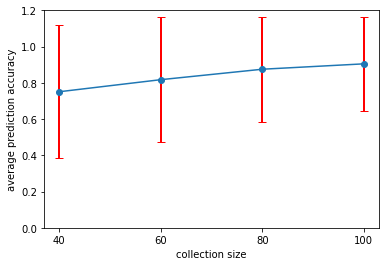

In [11]:
########### plt the result ##############

''' visulize the prediction interval comparison '''
#plt.errorbar(collection_size,mdm_loss_mean,yerr=mdm_loss_std/np.sqrt(1000),marker='o',label = 'mdm')
#plt.errorbar(x,y,yerr=dy,fmt='o',ecolor='r',color='b',elinewidth=2,capsize=4)
plt.errorbar(size,mean_assortment_accuarcy,yerr=std_assortment_accararcy,ecolor='r',marker='o',elinewidth=2,capsize=4)
#plt.errorbar(size,mdm_avg_len_interval,yerr=mdm_len_interval_se,ecolor='r',elinewidth=2,capsize=4,label = 'G-MDM without group')
y = [0.2,0.6,1.2]
plt.yticks(y,y)
plt.xticks(size,size)
plt.tick_params(labelsize=20)
plt.xlabel('collection size',fontsize = 20)
plt.ylabel('average prediction accuracy',fontsize = 20)
plt.tight_layout()
#plt.legend(loc='upper right')
#plt.title('Prediction Accuracy with different sizes of assortment collections')
plt.savefig('n7/summary/underlying_MDM_NEW.pdf')
plt.savefig('n7/summary/underlying_MDM_NEW.png')
plt.show()


In [8]:
summary = pd.DataFrame({'assortment size':size,'mean accuracy':mean_assortment_accuarcy,'std':std_assortment_accararcy})
summary.to_csv('n7/summary/accuracy_summary.csv')

In [9]:
summary

,assortment size,mean accuracy,std
0,40,0.750992,0.367104
1,60,0.817516,0.343815
2,80,0.875109,0.290208
3,100,0.904824,0.258198
